# Arbitrary state preparation using Model-Free Reinforcement Learning

This notebook showcases an application of the formalism introduced in PhysRevX.12.011059 (https://doi.org/10.1103/PhysRevX.12.011059) on arbitrary qubit state preparation, as depicted in the Appendix D.2b.

The implementation of the quantum environment is done here via Qiskit, using an Estimator primitive (https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/how-to-getting-started-with-estimator.html) for the execution of parametrized quantum circuits and Pauli expectation sampling.

Author of notebook: Arthur Strauss

Updated on 21/02/2024

In [1]:
import numpy as np
import os
import sys


from rl_qoc import QuantumEnvironment, QiskitConfig, BenchmarkConfig
from rl_qoc.helpers.tf_utils import select_optimizer, generate_model

# Qiskit imports for building RL environment (circuit level)

from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Cod

In [2]:
from qiskit import QuantumRegister


# Ansatz function, could be at pulse level or circuit level


def apply_parametrized_circuit(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    global n_actions
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], qreg[0])
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], qreg[1])
    qc.rzx(2 * np.pi * params[6], qreg[0], qreg[1])
    qc.u(2 * np.pi * params[7], 2 * np.pi * params[8], 2 * np.pi * params[9], qreg[1])
    qc.u(2 * np.pi * params[10], 2 * np.pi * params[11], 2 * np.pi * params[12], qreg[2])
    qc.rzx(2 * np.pi * params[13], qreg[1], qreg[2])

# Defining the QuantumEnvironment

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we can choose to go through the use of Qiskit Runtime, or to speed things up by using the local CPU and a state-vector simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

In [16]:
from gymnasium.spaces import Box

qubit_tgt_register = [0, 1, 2]  # Choose which qubits of the QPU you want to address
sampling_Paulis = 200
batchsize = (
    200  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
)
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector
n_actions = 14  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)
seed = 359
estimator_options = {"seed_simulator": seed, "resilience_level": 0}
action_space = Box(low=-1, high=1, shape=(n_actions,), dtype=np.float32)
observation_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)

Choose below which IBM Backend to use. As we are dealing with circuit level implementation, we can look for a backend supporting Qiskit Runtime (could be a cloud simulator, or real backend) or simply set backend to None and rely on the Estimator primitive based on statevector simulation. In either case, we need access to one Estimator primitive to run the algorithm, as the feedback from the measurement outcomes is done by calculating Pauli expectation values.

In [17]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend,
where Qiskit Runtime is enabled
"""

backend_name = "ibm_perth"

# service = QiskitRuntimeService(channel='ibm_quantum')
# runtime_backend = service.get_backend(backend_name)
# estimator_options = {'resilience_level': 0}

In [18]:
"""
If using Qiskit native Estimator primitive
(statevector simulation)
"""

no_backend = None

In [19]:
backend = no_backend

In [20]:
from qiskit.quantum_info import Statevector
from rl_qoc import StateTarget
# Define here target state density matrix

# Target state: GHZ state: (|000> + |111>)/sqrt(2)
target_state = StateTarget((Statevector.from_label("000")+Statevector.from_label("111"))/np.sqrt(2))
# print("Target state Density matrix:", target_state)

In [21]:
# Wrap all info in one dict Qiskit_setup
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
)

In [22]:
# Declare QuantumEnvironment variable
from rl_qoc import QEnvConfig, ExecutionConfig

# Define quantum environment
execution_config = ExecutionConfig(
    n_shots=N_shots,
    batch_size=batchsize,
    n_reps=1,
    sampling_paulis=sampling_Paulis,
    seed=seed,
    c_factor=1.0,
)
q_env_config = QEnvConfig(
    target=target_state,
    backend_config=Qiskit_setup,
    action_space=action_space,
    execution_config=execution_config,
    benchmark_config=BenchmarkConfig(1)
)
q_env = QuantumEnvironment(training_config=q_env_config)
print(q_env.target)

StateTarget(DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j]],
              dims=(2, 2, 2)) on qubits [0, 1, 2])


We now define the Agent, which will be in general a Deep Neural Network.
We start by defining the hyperparameters of the training

In [23]:
# Hyperparameters for the agent
n_epochs = 1500  # Number of epochs
opti = "Adam"
eta = 0.01  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.2  # Parameter for clipping value (PPO)
grad_clip = 0.1
critic_loss_coeff = 0.5
optimizer = select_optimizer(
    lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2
)
sigma_eps = 1e-3  # for numerical stability

In [24]:
# Policy parameters: generate NN that will output mean and variances of the policy

# Policy parameters
N_in = observation_space.shape[
    -1
]  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [100, 100, 100]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros(N_in)  # Here no feedback involved, so measurement sequence is always the same

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 100)          200         input_2[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 100)          10100       hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 100)          10100       hidden_1[0][0]                   
____________________________________________________________________________________________

In [25]:
# Plotting tools
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 10
%matplotlib inline

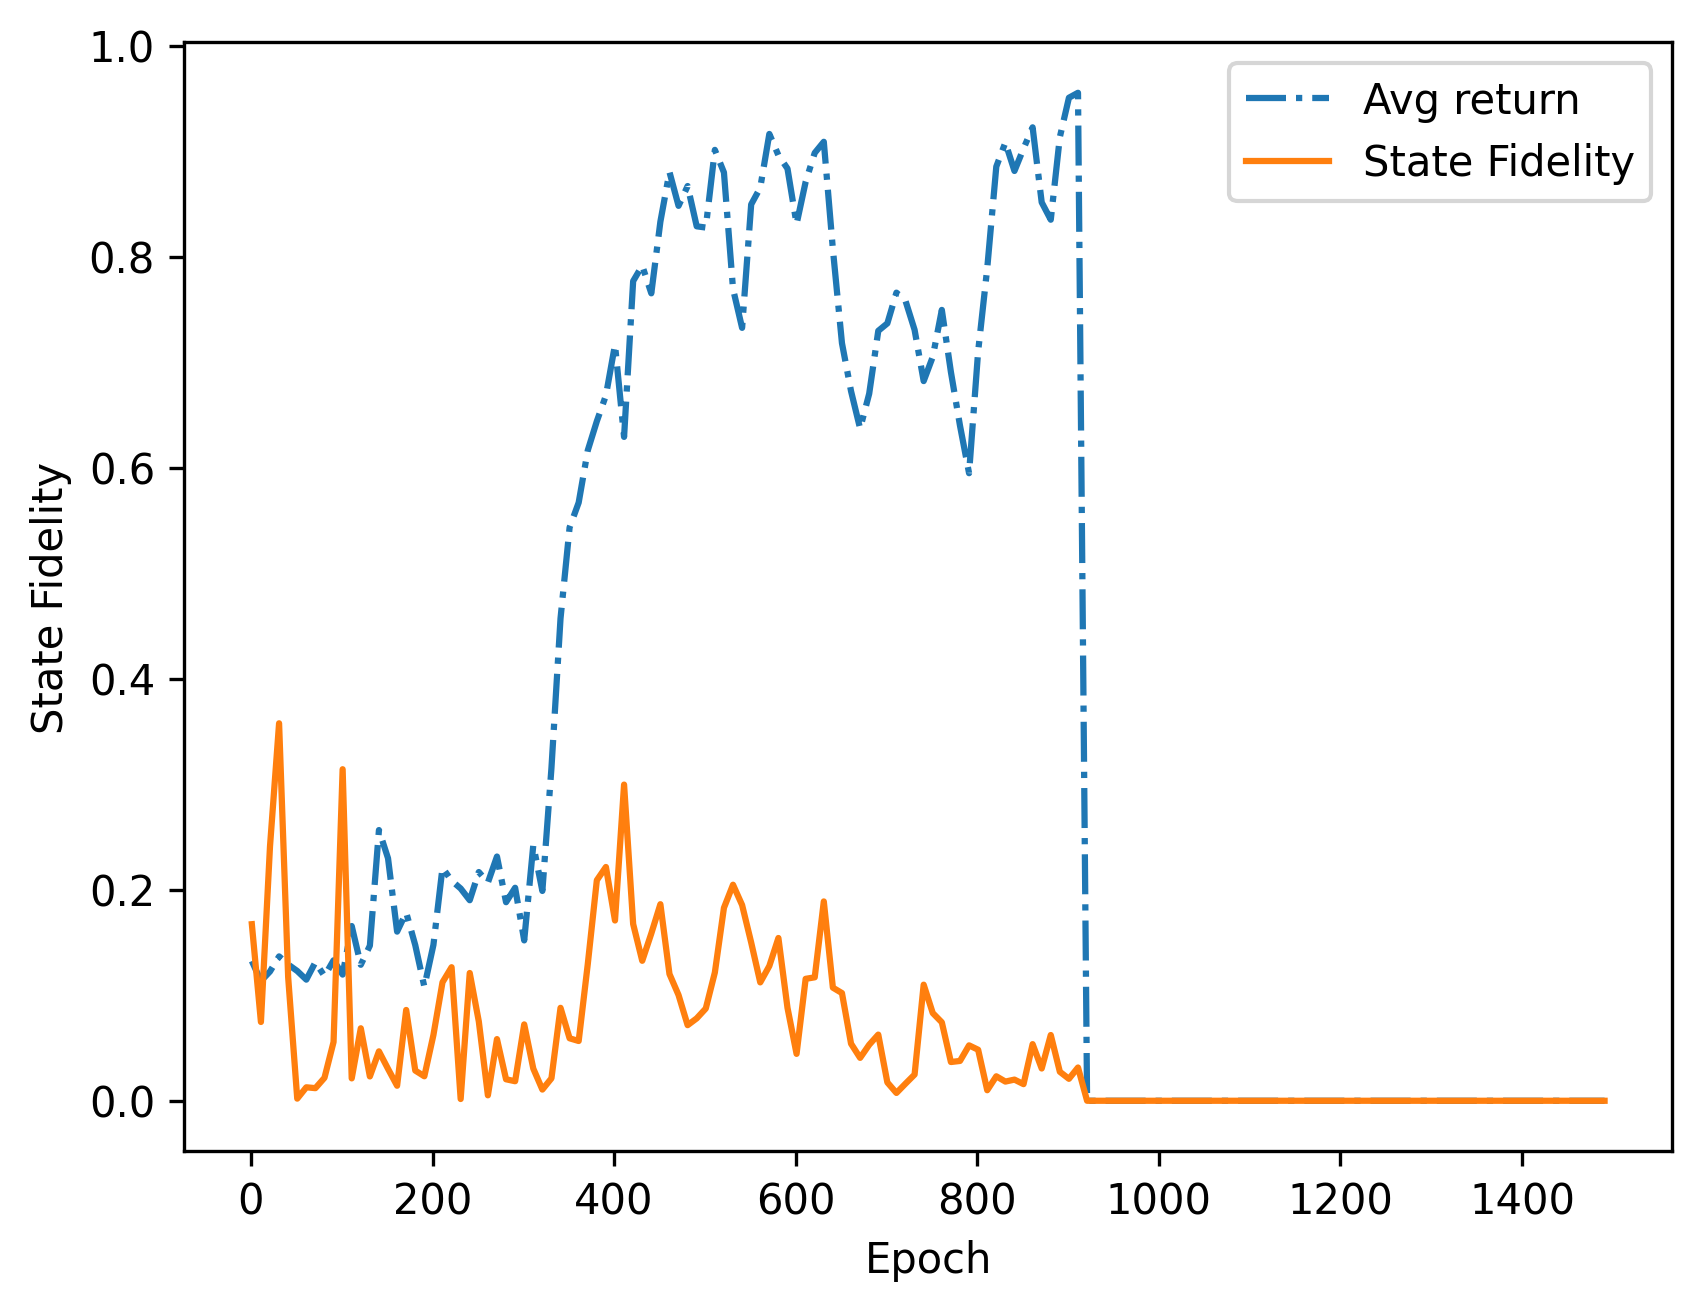

 61%|██████    | 911/1500 [04:24<02:57,  3.31it/s]

Maximum fidelity reached so far: 0.3956258249487799
tf.Tensor(
[[-0.7617439   0.5022261  -0.22902803 -0.26800266  0.80602336 -0.77780646
   0.96995294 -0.77277434  0.24048151  0.8634001  -0.75143486  0.02300257
  -0.63641125  0.6447454 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.7617439   0.5022261  -0.22902803 -0.26800266  0.80602336 -0.77780646
  0.96995294 -0.77277434  0.24048151  0.8634001  -0.75143486  0.02300257
 -0.63641125  0.6447454 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.053111355575139386]
Finished simulation benchmark


 61%|██████    | 912/1500 [04:24<02:52,  3.40it/s]

Reward (avg): 0.9554121618619946 Std: 0.019619711381049548
Fidelity 0.053111355575139386
tf.Tensor(
[[-0.74691767  0.48740008 -0.24625061 -0.26081967  0.8107143  -0.77090496
   0.9719424  -0.7630949   0.2572938   0.85868555 -0.7594984   0.0154845
  -0.6201465   0.6330021 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.74691767  0.48740008 -0.24625061 -0.26081967  0.8107143  -0.77090496
  0.9719424  -0.7630949   0.2572938   0.85868555 -0.7594984   0.0154845
 -0.6201465   0.6330021 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.0580173657983087]
Finished simulation benchmark


 61%|██████    | 913/1500 [04:25<02:48,  3.49it/s]

Reward (avg): 0.9641056187740014 Std: 0.015592823584199804
Fidelity 0.0580173657983087
tf.Tensor(
[[-0.745045    0.49321657 -0.23604247 -0.28036204  0.82275593 -0.77490443
   0.9740636  -0.75386524  0.25443217  0.85883516 -0.7632962   0.02331918
  -0.62243     0.6447437 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.745045    0.49321657 -0.23604247 -0.28036204  0.82275593 -0.77490443
  0.9740636  -0.75386524  0.25443217  0.85883516 -0.7632962   0.02331918
 -0.62243     0.6447437 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.07325975142395973]
Finished simulation benchmark


 61%|██████    | 914/1500 [04:25<02:45,  3.54it/s]

Reward (avg): 0.952889435789522 Std: 0.02008078751324245
Fidelity 0.07325975142395973
tf.Tensor(
[[-0.75113165  0.48158005 -0.2594684  -0.27078286  0.8256577  -0.76844865
   0.9769512  -0.7462774   0.27685815  0.8551436  -0.75888664  0.01797511
  -0.6310832   0.63360274]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.75113165  0.48158005 -0.2594684  -0.27078286  0.8256577  -0.76844865
  0.9769512  -0.7462774   0.27685815  0.8551436  -0.75888664  0.01797511
 -0.6310832   0.63360274], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.06876808211604706]
Finished simulation benchmark


 61%|██████    | 915/1500 [04:25<02:43,  3.58it/s]

Reward (avg): 0.9543975216563864 Std: 0.02125755234029258
Fidelity 0.06876808211604706
tf.Tensor(
[[-0.75092596  0.490981   -0.24859485 -0.28715506  0.8252962  -0.7731386
   0.97937137 -0.7519934   0.27588233  0.85573715 -0.7651546   0.02512929
  -0.6318287   0.6461474 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.75092596  0.490981   -0.24859485 -0.28715506  0.8252962  -0.7731386
  0.97937137 -0.7519934   0.27588233  0.85573715 -0.7651546   0.02512929
 -0.6318287   0.6461474 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.0852912678439518]
Finished simulation benchmark


 61%|██████    | 916/1500 [04:26<02:43,  3.56it/s]

Reward (avg): 0.9408134649520136 Std: 0.025878971820971323
Fidelity 0.0852912678439518
tf.Tensor(
[[-0.74730253  0.47868496 -0.26117435 -0.27871096  0.83012426 -0.77809626
   0.9814717  -0.76030105  0.25980052  0.85009277 -0.76222754  0.00956978
  -0.6186363   0.6370671 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.74730253  0.47868496 -0.26117435 -0.27871096  0.83012426 -0.77809626
  0.9814717  -0.76030105  0.25980052  0.85009277 -0.76222754  0.00956978
 -0.6186363   0.6370671 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.06712979416826555]
Finished simulation benchmark


 61%|██████    | 917/1500 [04:26<02:41,  3.60it/s]

Reward (avg): 0.9534625434906822 Std: 0.021521957344694066
Fidelity 0.06712979416826555
tf.Tensor(
[[-0.7548601   0.4865778  -0.24642459 -0.26448473  0.8307742  -0.7933386
   0.98291814 -0.7655331   0.2559646   0.8413639  -0.7691322   0.01297197
  -0.62391233  0.65075696]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.7548601   0.4865778  -0.24642459 -0.26448473  0.8307742  -0.7933386
  0.98291814 -0.7655331   0.2559646   0.8413639  -0.7691322   0.01297197
 -0.62391233  0.65075696], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.06415136755986332]
Finished simulation benchmark


 61%|██████    | 918/1500 [04:26<02:48,  3.46it/s]

Reward (avg): 0.948133307215196 Std: 0.02144527763893128
Fidelity 0.06415136755986332
tf.Tensor(
[[-0.7486174   0.47233355 -0.2562549  -0.25858614  0.8313798  -0.7949152
   0.9834405  -0.7559133   0.27091235  0.83472234 -0.76191634  0.00390893
  -0.6098463   0.6448489 ]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.7486174   0.47233355 -0.2562549  -0.25858614  0.8313798  -0.7949152
  0.9834405  -0.7559133   0.27091235  0.83472234 -0.76191634  0.00390893
 -0.6098463   0.6448489 ], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.06862898252586241]
Finished simulation benchmark


 61%|██████▏   | 919/1500 [04:26<02:45,  3.51it/s]

Reward (avg): 0.9467843252829001 Std: 0.02055915165860325
Fidelity 0.06862898252586241
tf.Tensor(
[[-0.75742656  0.4820055  -0.24557573 -0.2506125   0.8327016  -0.8081497
   0.98495454 -0.7631977   0.26596192  0.8373677  -0.77074414  0.00282539
  -0.6157668   0.65693605]], shape=(1, 14), dtype=float32)
tf.Tensor(
[-0.75742656  0.4820055  -0.24557573 -0.2506125   0.8327016  -0.8081497
  0.98495454 -0.7631977   0.26596192  0.8373677  -0.77074414  0.00282539
 -0.6157668   0.65693605], shape=(14,), dtype=float32)
Starting simulation benchmark...
State fidelity: [0.06736402456960346]
Finished simulation benchmark


 61%|██████▏   | 919/1500 [04:27<02:48,  3.44it/s]

Reward (avg): 0.9345769517935962 Std: 0.02236390690708022


KeyboardInterrupt: 

In [26]:
# Training loop

mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

policy_params_str = "Policy params:"

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(
        loc=mu_old, scale_diag=sigma_old, validate_args=True, allow_nan_stats=False
    )
    obs, _ = q_env.reset()
    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(obs, training=True)
        print(mu)
        mu = tf.squeeze(mu, axis=0)
        print(mu)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)
        q_env.mean_action = np.array(mu)
        q_env.std_action = np.array(sigma)
        Policy_distrib = MultivariateNormalDiag(
            loc=mu, scale_diag=sigma, validate_args=True, allow_nan_stats=False
        )

        action_vector = tf.stop_gradient(
            tf.clip_by_value(Policy_distrib.sample(batchsize), -1.0, 1.0)
        )

        _, reward, _, _, _ = q_env.step(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (
                tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-7
            )
            actor_loss = -tf.reduce_mean(
                tf.minimum(
                    advantage * ratio,
                    advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon),
                )
            )
        else:  # REINFORCE algorithm
            actor_loss = -tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage**2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)
    avg_return[i] = np.mean(q_env.reward_history, axis=1)[i]
    fidelities[i] = q_env.circuit_fidelity_history[i]
    print("Fidelity", fidelities[i])
    if i % visualization_steps == 0:
        clear_output(wait=True)  # for animation
        fig, ax = plt.subplots()
        ax.plot(
            np.arange(1, n_epochs, visualization_steps),
            avg_return[0:-1:visualization_steps],
            "-.",
            label="Avg return",
        )
        ax.plot(
            np.arange(1, n_epochs, visualization_steps),
            fidelities[0:-1:visualization_steps],
            label="State Fidelity",
        )
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities))

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
q_env.close()

In [14]:
print("Maximum fidelity reached:", np.max(fidelities), "at Epoch ", np.argmax(fidelities))

Maximum fidelity reached: 0.42217659242642025 at Epoch  30


Text(0, 0.5, 'Average return')

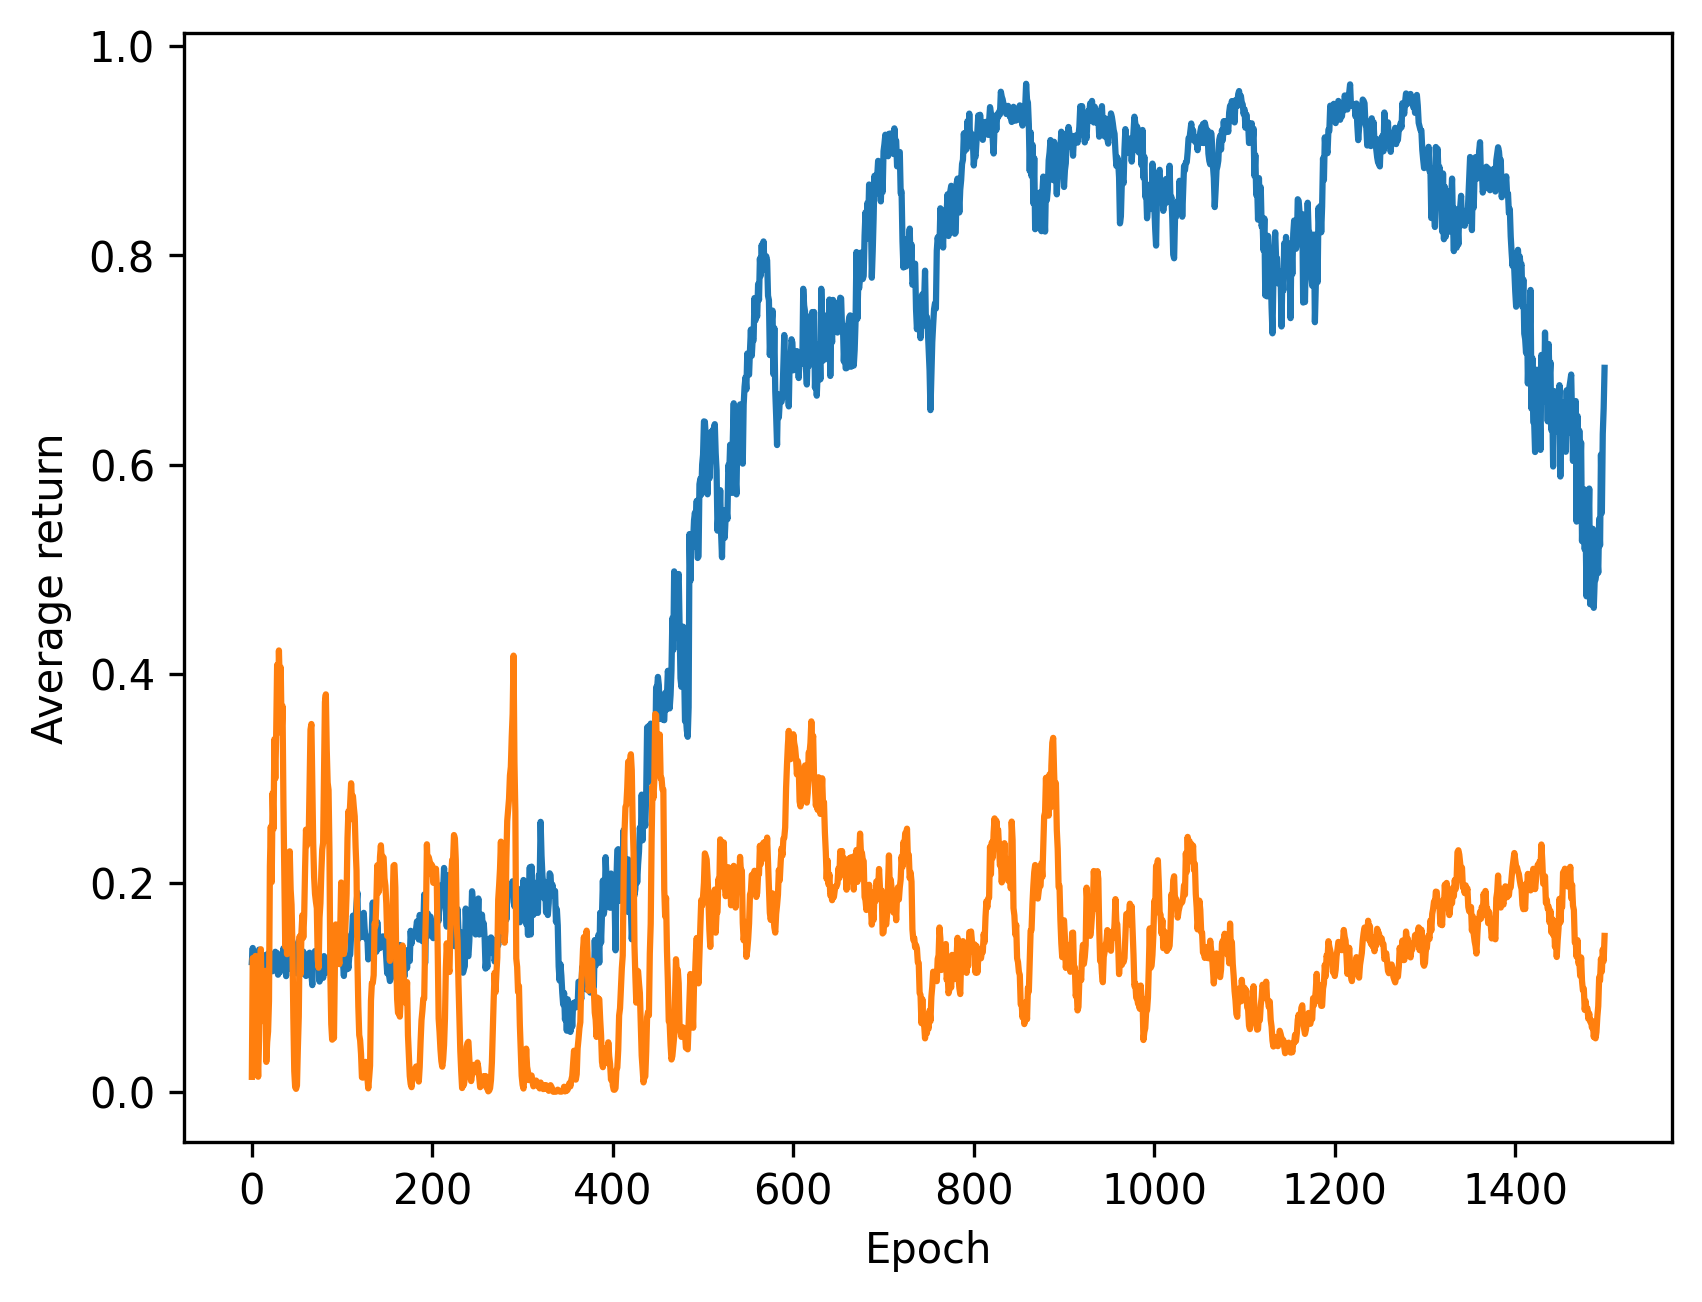

In [15]:
plt.plot(np.mean(q_env.reward_history, axis=1), label="Average return")
plt.plot(q_env.circuit_fidelity_history, label="State fidelity")
plt.xlabel("Epoch")
plt.ylabel("Average return")